In [21]:
import json
import requests
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import sleep
from math import floor

# Read the Kraken 2 report file

def getTaxonsDataReport(taxons, name_save):

    print(f"Quantity of taxons: {len(taxons)}")
    div = floor(len(taxons) / 500)
    taxons_subset = []

    j = 0
    for n in range(1, div+1):
        taxons_subset.append(taxons[j*500:n*500])
        j += 1

    if taxons[div*500:]:
        taxons_subset.append(taxons[div*500:])

    tamanho_taxons = 0

    for i in taxons_subset:
        tamanho_taxons += len(i)

    if tamanho_taxons != len(taxons):
        print("The total taxons in taxons_subset is different of set ")
        print(tamanho_taxons, len(taxons))
        sys.exit(1)

    
    # Create an Endpoint for taxonomy dataset_report   
    url = "https://api.ncbi.nlm.nih.gov/datasets/v2alpha/taxonomy/dataset_report"

    # Create a simple header
    headers = {
        'Content-Type': 'application/json',
        "api-key": "5fef613731c42579410dd5e37d144fb0e608"
    }

    response_merged = {"reports": [], "total_count": 0}
    index = 0
    tempo = 10
    while index < len(taxons_subset):

        # Pass taxon Data
        data = {
            "taxons": taxons_subset[index]

        }
        response = requests.post(url, json=data, headers=headers)
        
        if response.status_code == 200:
            response = response.json()
            print(f"Post request success {index}/{len(taxons_subset)}")
            response_merged = {"reports": response_merged["reports"] + response["reports"],
                               "total_count": response_merged["total_count"] + response["total_count"]}
            sleep(1)
            index += 1
        else:
            print("Post request failed:", response.status_code)
            print(f"Waiting {tempo}s ...")
            sleep(tempo)
            tempo += 10
            print("Trying again...")

    with open(f"ncbiResponse_{name_save}.json", "+w") as f:
        json.dump(response_merged, f, ensure_ascii=False, indent=4)
    return response_merged

def readReport(kraken2_report_file):
    classified_sequences = []

    # Open the report file and extract classified sequences
    with open(kraken2_report_file, "r") as report:
        for line in report:
            # Split each line by tab
            columns = line.strip().split("\t")
            # Check if the sequence was classified (non-zero taxid)
            if int(columns[2]) != 0:
                # Extract the sequence ID (first column)
                #sequence_id = columns[0]
                classified_sequences.append(line)

    return classified_sequences

def outputClassified(sample_name, classified_sequences):

    # Output the classified sequences to a new file
    with open(f"classified_seq_{sample_name}", "w") as output:
        for sequence_id in classified_sequences:
            output.write(sequence_id + "\n")

def extractTaxons(classified_sequences):
    taxons = {}

    for line in classified_sequences:
        column = line.strip().split("\t")

        taxon = column[2]
        if taxon in taxons.keys():

            taxons[taxon] += 1
        else:
            taxons[taxon] = 1

    # Sort taxons
    taxons = {x: y for x, y in sorted(taxons.items(), key=lambda item: item[1], reverse=True)}

    return taxons

def getUsefulDataResponse(response, taxons):

    CATEGORIES = ["superkingdom", "kingdom", "phylum", "class", "order", "genus", "family", "species"]

    reports = response["reports"]

    organisms = {"reports": {}, "counts": {}}
    counts = {
        "rank": {},
        "classification": {
            "superkingdom": {},
            "kingdom": {},
            "phylum": {},
            "class": {},
            "order": {},
            "genus": {},
            "family": {},
            "species": {}
        },
        "taxons": taxons
    }
    for report in reports[:-1]:

        del report["query"]

        taxonomy = report["taxonomy"]
        tax_id = taxonomy["tax_id"]
        taxonomy_keys = taxonomy.keys()

        if "rank" not in taxonomy_keys:
            taxonomy["rank"] = "NO RANK"

        rank = taxonomy["rank"]

        
        if rank in counts["rank"]:
            counts["rank"][rank] += 1
        else:
            counts["rank"][rank] = 1

        for category in taxonomy["classification"].keys():
            name = taxonomy["classification"][category]["name"]
            taxonomy["classification"][category] = name

            if name in counts["classification"][category].keys():
                counts["classification"][category][name] += 1
            else:
                counts["classification"][category][name] = 1

        taxo_class = taxonomy["classification"]

        for categ in CATEGORIES:
            if categ not in taxo_class:
                taxo_class[categ] = None
        taxonomy["current_scientific_name"] = taxonomy["current_scientific_name"]["name"]

        if "group_name" in taxonomy_keys: del taxonomy["group_name"]
        if "curator_common_name" in taxonomy_keys: del taxonomy["curator_common_name"]
        if "genomic_moltype" in taxonomy_keys: del taxonomy["genomic_moltype"]
        if "counts" in taxonomy_keys: del taxonomy["counts"]

        organisms["reports"][tax_id] = taxonomy
        organisms["counts"] = counts

    return organisms

def jsonToDataFrame(path, sample_name):
    CATEGORIES = ["superkingdom", "kingdom", "phylum", "class", "order", "genus", "family", "species"]
    with open(f"{path}") as f:
        data = json.load(f)

    classifications = data["counts"]["classification"]

    dataFrames = {}

    for categ in CATEGORIES:

        df = pd.DataFrame({categ: list(classifications[categ].keys()), sample_name: list(classifications[categ].values())}).set_index(categ)

        dataFrames[categ] = df
        
    return dataFrames

def makeGraphTaxon(path, sample_name):
    CATEGORIES = ["superkingdom", "kingdom", "phylum", "class", "order", "genus", "family", "species"]
    with open(f"{path}") as f:
        data = json.load(f)
        
        
    adjacency_dict = {}
    taxonsDf = list(data["counts"]["taxons"].keys())
    
    for taxon in taxonsDf:
        adjacency_dict[taxon] = []
        for parent in data["reports"][taxon]["parents"]:
            if parent in taxonsDf: adjacency_dict[taxon].append(parent)
            
        
    
    

def mergeDataFrame(dfs: list, dict=None):
    CATEGORIES = ["superkingdom", "kingdom", "phylum", "class", "order", "genus", "family", "species"]
    dfsNew = {}
    if not dict:
        
        for categ in CATEGORIES:
            dfCateg = [i[categ] for i in dfs]
            dfMerged = pd.concat(dfCateg, axis = 1).fillna(0)
            dfsNew[categ] = dfMerged
    else:
        for categ in CATEGORIES:
            dfCateg = [i[categ] for i in dfs]
            dfCateg.append(dict[categ])
            dfMerged = pd.concat(dfCateg, axis = 1).fillna(0)           
            dfsNew[categ] = dfMerged
    return dfsNew

def splitDf(df, n, others=True):
    
    sorted_df = df.loc[df.sum(axis=1).sort_values(ascending=False).index, :]
    
    n_df = sorted_df[:n]

    
    if others:
        n_df.loc["others"] = sorted_df[sorted_df.columns][n:].sum()
        
    
    return n_df
    
def relativeDf(df):
    
    relative_df = (df)/(df.sum())
    
    return relative_df

def abundancePlot(df, name, palette="hsl"):


    ax = df.T.plot.barh(stacked=True, color= sns.color_palette(palette, len(df)), edgecolor='black')

    plt.xlabel('Amostras')
    plt.ylabel('Abundância Relativa (%)')
    plt.title('Abundância de bacteriófagos')
    plt.legend(title='Bacteriófagos',  bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.figure(figsize=(24, 20))
    plt.savefig(name+".png",  bbox_inches='tight', pad_inches=0.5)
    plt.show()

def preprocessingDf(df, n, others=True, plot = True, palette="hls", name="abundance"):
    n_df = splitDf(df, n, others)
    relative_df = relativeDf(n_df)

    if plot:
        abundancePlot(relative_df, name, palette )
    
    return relative_df
    

def saveOrganism(kraken2_report_file, sample_name):
    
    classified_sequences = readReport(kraken2_report_file)
    
    outputClassified(sample_name, classified_sequences)

    print(f"Total classified sequences in {sample_name}:", len(classified_sequences))

    taxons = extractTaxons(classified_sequences)

    taxonsDataReport = getTaxonsDataReport(list(taxons.keys()), sample_name)

    organisms = getUsefulDataResponse(taxonsDataReport, taxons)

    with open(f"organisms_{sample_name}.json", "w") as f:
        json.dump(organisms, f)


def pipeLine(path, base_name, n, save=True):

    
    dfsMeta = []
    
    for i in range(1, n+1):
        name = f"{base_name}{i}.kraken"
        pathFull = path + name
        if save:
            saveOrganism(pathFull, f"{base_name}{i}")
        dfsMeta.append(jsonToDataFrame(f"organisms_{base_name}{i}.json", f"{base_name}{i}"))
    
    dfMerged = mergeDataFrame(dfsMeta)
    
    return dfMerged
    
        

In [22]:
# Importing necessary libraries
import numpy as np
from scipy.spatial import distance_matrix
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
import matplotlib.pyplot as plt



In [23]:
meta2 = extractTaxons(readReport("/home/carlos23001/IP/Dados/Meta_2.kraken"))

PermissionError: [Errno 13] Permission denied: '/home/carlos23001/IP/Dados/Meta_2.kraken'

In [ ]:
meta2["2731619"]

NameError: name 'meta2' is not defined

In [ ]:
meta2t = readReport("Meta_2.kraken")

In [ ]:
len(meta2t)

13079

In [39]:
dfMerged = pipeLine("/home/llemos/metagenomicDataIP2/inputKraken/", "Meta_", 59, save=False)

In [40]:
dfMerged["order"]

,Meta_1,Meta_2,Meta_3,Meta_4,Meta_5,Meta_6,Meta_7,Meta_8,Meta_9,Meta_10,...,Meta_50,Meta_51,Meta_52,Meta_53,Meta_54,Meta_55,Meta_56,Meta_57,Meta_58,Meta_59
order,,,,,,,,,,,,,,,,,,,,,
Herpesvirales,57.0,46.0,57.0,61.0,42.0,69.0,50.0,52.0,78.0,57.0,...,52.0,41.0,40.0,38.0,50.0,55.0,39.0,55.0,73.0,50.0
Lefavirales,53.0,40.0,61.0,43.0,40.0,47.0,47.0,49.0,72.0,61.0,...,45.0,40.0,51.0,41.0,40.0,50.0,43.0,45.0,47.0,45.0
Pimascovirales,17.0,23.0,23.0,20.0,17.0,21.0,23.0,19.0,31.0,22.0,...,20.0,18.0,20.0,16.0,20.0,22.0,17.0,22.0,21.0,18.0
Imitervirales,22.0,23.0,22.0,22.0,20.0,24.0,23.0,23.0,24.0,24.0,...,24.0,23.0,24.0,24.0,22.0,24.0,26.0,24.0,22.0,23.0
Reovirales,7.0,3.0,12.0,8.0,7.0,11.0,6.0,11.0,16.0,11.0,...,7.0,4.0,6.0,5.0,10.0,10.0,5.0,6.0,8.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Serpentovirales,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
Recrevirales,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Vinavirales,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
df = dfMerged["order"].transpose()
df

order,Herpesvirales,Lefavirales,Pimascovirales,Imitervirales,Reovirales,Mononegavirales,Chitovirales,Amarillovirales,Crassvirales,Bunyavirales,...,Kirjokansivirales,Polivirales,Rivendellvirales,Rohanvirales,Maximonvirales,Serpentovirales,Recrevirales,Vinavirales,Goujianvirales,Magrovirales
Meta_1,57.0,53.0,17.0,22.0,7.0,29.0,28.0,10.0,85.0,36.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Meta_2,46.0,40.0,23.0,23.0,3.0,40.0,30.0,7.0,73.0,37.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Meta_3,57.0,61.0,23.0,22.0,12.0,41.0,40.0,6.0,83.0,47.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Meta_4,61.0,43.0,20.0,22.0,8.0,36.0,32.0,8.0,80.0,37.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Meta_5,42.0,40.0,17.0,20.0,7.0,29.0,31.0,5.0,74.0,38.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Meta_6,69.0,47.0,21.0,24.0,11.0,31.0,36.0,4.0,87.0,38.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Meta_7,50.0,47.0,23.0,23.0,6.0,32.0,32.0,1.0,76.0,48.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Meta_8,52.0,49.0,19.0,23.0,11.0,41.0,35.0,5.0,81.0,35.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Meta_9,78.0,72.0,31.0,24.0,16.0,73.0,44.0,8.0,83.0,58.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Meta_10,57.0,61.0,22.0,24.0,11.0,40.0,27.0,11.0,62.0,45.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


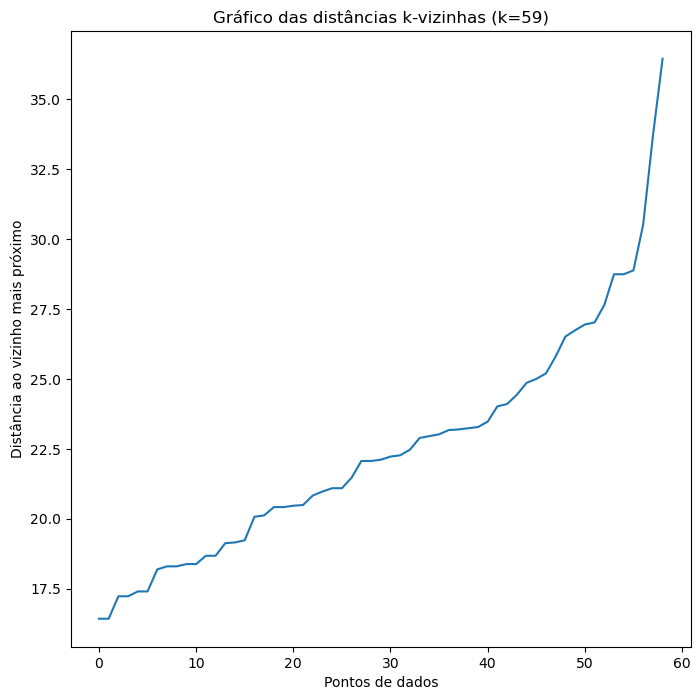

In [84]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestNeighbors

# Calculando as distâncias k-vizinhas
neighbors = NearestNeighbors(n_neighbors=59)
neighbors_fit = neighbors.fit(df)
distances, indices = neighbors_fit.kneighbors(df)

# Ordenando as distâncias
distances = np.sort(distances[:,1], axis=0)

# Plotando o gráfico das distâncias k-vizinhas
plt.figure(figsize=(8,8))
plt.plot(distances)
plt.xlabel('Pontos de dados')
plt.ylabel('Distância ao vizinho mais próximo')
plt.title('Gráfico das distâncias k-vizinhas (k=59)')
plt.show()


In [85]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=29, min_samples=5).fit(df)
cluster = clustering.labels_

In [86]:
(set(cluster))


{-1, 0}

In [87]:
# Obter os rótulos dos clusters
clusters = clustering.labels_

# Adicionar os rótulos dos clusters ao DataFrame transposto
df['Cluster'] = clusters



# Mostrar as metas com seus respectivos grupos
for meta, cluster in zip(df.index, df['Cluster']):
    print(f"{meta}: Grupo {cluster}")

Meta_1: Grupo 0
Meta_2: Grupo 0
Meta_3: Grupo 0
Meta_4: Grupo 0
Meta_5: Grupo 0
Meta_6: Grupo 0
Meta_7: Grupo 0
Meta_8: Grupo 0
Meta_9: Grupo -1
Meta_10: Grupo 0
Meta_11: Grupo 0
Meta_12: Grupo 0
Meta_13: Grupo 0
Meta_14: Grupo 0
Meta_15: Grupo -1
Meta_16: Grupo -1
Meta_17: Grupo 0
Meta_18: Grupo 0
Meta_19: Grupo -1
Meta_20: Grupo 0
Meta_21: Grupo 0
Meta_22: Grupo 0
Meta_23: Grupo 0
Meta_24: Grupo 0
Meta_25: Grupo 0
Meta_26: Grupo -1
Meta_27: Grupo 0
Meta_28: Grupo 0
Meta_29: Grupo 0
Meta_30: Grupo 0
Meta_31: Grupo 0
Meta_32: Grupo 0
Meta_33: Grupo 0
Meta_34: Grupo 0
Meta_35: Grupo 0
Meta_36: Grupo 0
Meta_37: Grupo 0
Meta_38: Grupo 0
Meta_39: Grupo 0
Meta_40: Grupo 0
Meta_41: Grupo 0
Meta_42: Grupo 0
Meta_43: Grupo 0
Meta_44: Grupo 0
Meta_45: Grupo 0
Meta_46: Grupo 0
Meta_47: Grupo 0
Meta_48: Grupo 0
Meta_49: Grupo 0
Meta_50: Grupo 0
Meta_51: Grupo 0
Meta_52: Grupo 0
Meta_53: Grupo 0
Meta_54: Grupo 0
Meta_55: Grupo 0
Meta_56: Grupo 0
Meta_57: Grupo 0
Meta_58: Grupo 0
Meta_59: Grupo 0


# Knn

In [80]:
from sklearn.cluster import KMeans

# Supondo que X seja o seu conjunto de dados
# Defina o número de clusters que você deseja, por exemplo, 3
num_clusters = 2

# Inicialize o K-Means com o número de clusters desejado
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Ajuste (fit) o modelo aos dados
clustering = kmeans.fit(df)

# Obter os rótulos dos clusters
clusters = clustering.labels_

# Adicionar os rótulos dos clusters ao DataFrame transposto
df['Cluster'] = clusters



# Mostrar as metas com seus respectivos grupos
um = 0
zero = 0
for meta, cluster in zip(df.index, df['Cluster']):
    #print(f"{meta}: Grupo {cluster}")
    if int(str(meta[-2:].replace("_", "")))  >= 21:
        if cluster == 1:
            um += 1
        if cluster == 0:
            zero += 1




In [81]:
zero

15

In [82]:
um

24

In [ ]:
orderNumpy = dfMerged["order"].T.to_numpy()

In [ ]:
len(orderNumpy)

50

In [ ]:
distances = squareform(pdist(orderNumpy, metric="braycurtis"))

In [ ]:
print(orderNumpy)

[[57. 53. 17. ...  0.  0.  0.]
 [46. 40. 23. ...  0.  0.  0.]
 [57. 61. 23. ...  0.  0.  0.]
 ...
 [51. 47. 21. ...  0.  0.  0.]
 [66. 62. 21. ...  0.  0.  0.]
 [52. 45. 20. ...  0.  0.  0.]]


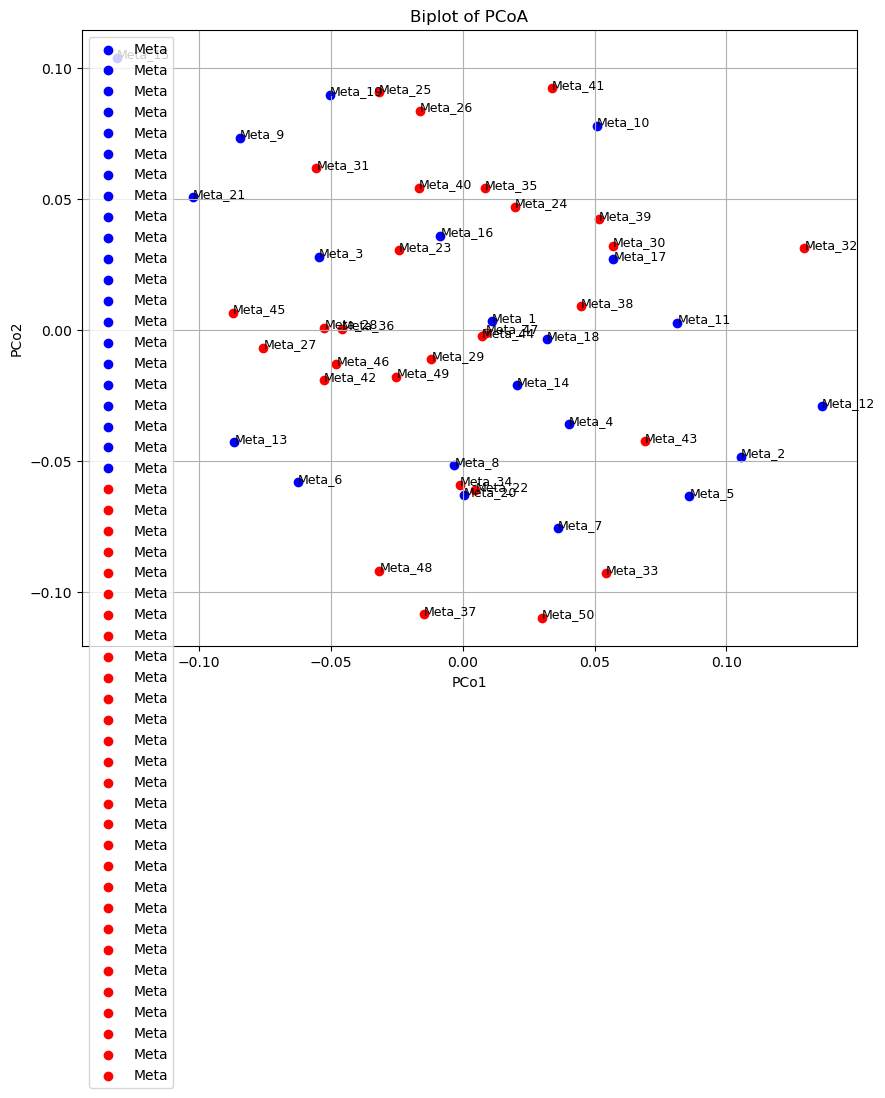

In [ ]:
mds = MDS(n_components=3, dissimilarity='precomputed', random_state=42)
coordinates = mds.fit_transform(distances)

# Extracting components from embedding_
components = mds.embedding_.transpose()

# Plotting the biplot
plt.figure(figsize=(10, 8))




# Adding variable loadings as arrows
# for i in range(dfMerged["order"].shape[1]):
#     plt.arrow(0, 0, components[0, i], components[1, i], color='red', alpha=0.5,
#               head_width=0.01, head_length=0.01)
#     plt.text(components[0, i] * 1.15, components[1, i] * 1.15,
#              'Variable {}'.format(i+1), color='red')

# Adding sample labels
for i in range(len(coordinates)):
    if i <= 20:
        color = "blue"
    else:
        color = "red"
    plt.scatter(coordinates[i, 0], coordinates[i, 1], color=color, label='Meta')
    plt.text(coordinates[i, 0], coordinates[i, 1], 'Meta_{}'.format(i+1), fontsize=9)

# Adding labels and title
plt.xlabel('PCo1')
plt.ylabel('PCo2')
plt.title('Biplot of PCoA')

plt.grid(True)
plt.legend()
plt.show()

In [ ]:
taxonv = "phylum"

In [ ]:
dfI, dfT = {}, {}

In [ ]:
for i in list(dfMerged.keys()):
    dfI[i] = dfMerged[i].iloc[:, :20]

for i in list(dfMerged.keys()):
    dfT[i] = dfMerged[i].iloc[:, 20:]

/tmp/ipykernel_3730464/514771070.py:243: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n_df.loc["others"] = sorted_df[sorted_df.columns][n:].sum()


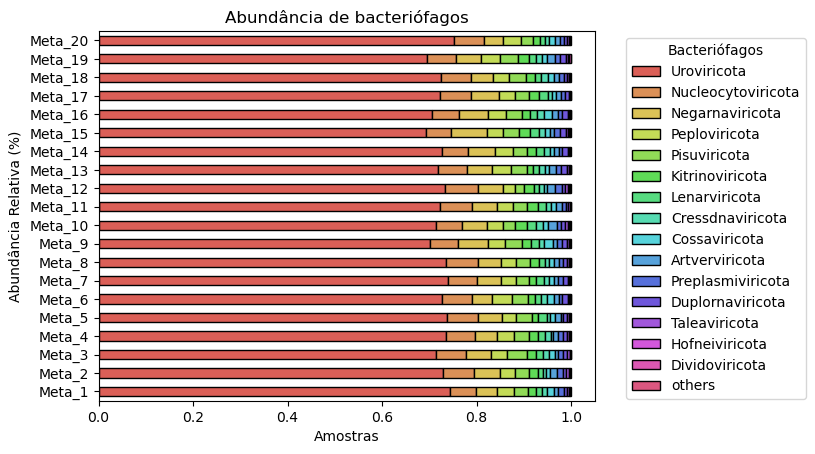

<Figure size 2400x2000 with 0 Axes>

In [ ]:
df_abundance_I = preprocessingDf(dfI[taxonv], 15, name="philoI")

/tmp/ipykernel_3730464/514771070.py:243: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n_df.loc["others"] = sorted_df[sorted_df.columns][n:].sum()


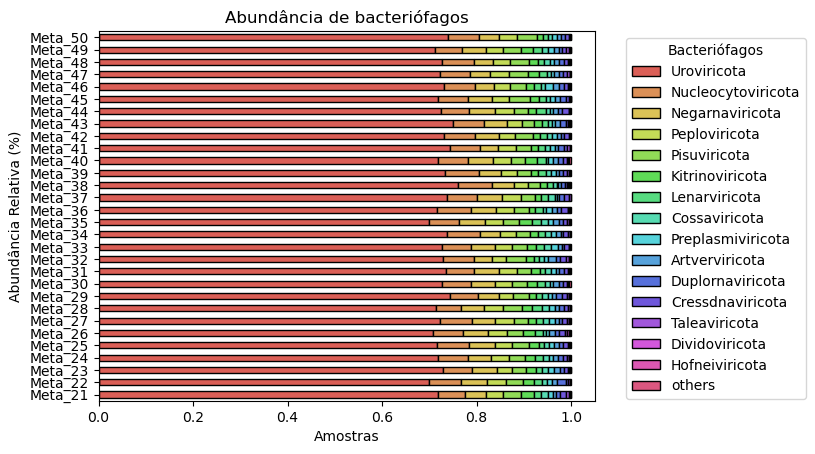

<Figure size 2400x2000 with 0 Axes>

In [ ]:
df_abundance_T = preprocessingDf(dfT[taxonv], 15, name="philoT")

In [ ]:
def boxplot(dfs:list, names:list, coord: tuple, name="boxplot"):
    fig, axs = plt.subplots(coord[0], coord[1])

    #df = pd.concat(dfs, keys=names, axis=1)
    #print(df.iloc[0, :].values)
    plt.figure(figsize=(24, 20))
    i = 0
    
    for ax in axs.reshape(-1):
        data = []
        for df in dfs:
            data.append(df.iloc[i, :].values)
        ax.boxplot(data)
        ax.set_title(df.iloc[i].name, fontsize=10)
        ax.set_xticklabels(['T', 'I'])
        i+= 1
        

    # plt.tight_layout(pad=2.0) 
    
    fig.tight_layout()
    fig.savefig(name+'.png', bbox_inches='tight', pad_inches=0.5)
    plt.show()

    plt.close()

In [ ]:
df_abundance_T_mean = df_abundance_T.T.mean()

In [ ]:
df_abundance_I_mean = df_abundance_I.T.mean()

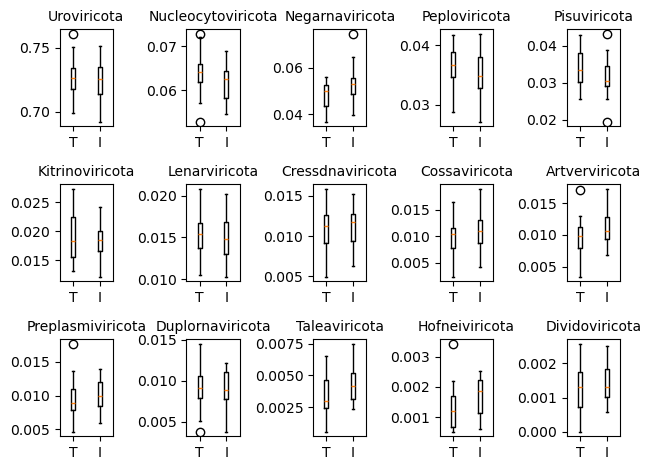

<Figure size 2400x2000 with 0 Axes>

In [ ]:
boxplot([df_abundance_T, df_abundance_I], ["T", "I"], (3,5), name="boxplot_philo")


In [ ]:
plt.close()

In [ ]:
df_abundance_T.T.mean()

phylum
Uroviricota           0.726365
Nucleocytoviricota    0.064017
Negarnaviricota       0.048396
Peploviricota         0.036453
Pisuviricota          0.034050
Kitrinoviricota       0.019049
Lenarviricota         0.015311
Cossaviricota         0.010851
Preplasmiviricota     0.009875
Artverviricota        0.009615
Duplornaviricota      0.009398
Cressdnaviricota      0.009243
Taleaviricota         0.003341
Dividoviricota        0.001312
Hofneiviricota        0.001310
others                0.001413
dtype: float64

In [ ]:
dfT["family"].T.mean()

family
Kyanoviridae          47.655172
Poxviridae            33.758621
Orthoherpesviridae    51.379310
Baculoviridae         46.344828
Straboviridae         70.827586
                        ...    
Barnaviridae           0.034483
Metaviridae            0.068966
Clavaviridae           0.034483
Yueviridae             0.137931
Spiraviridae           0.068966
Length: 241, dtype: float64

In [ ]:
abs((dfI["family"].T.mean() - dfT["family"].T.mean())).max()

8.03448275862069